Student Name: Hoang Tu Bui  

Student ID: 24005665

# Activity 6: Pytorch and CNNs for Fashion-MNIST

In this activity, we are going to explore designing various neural networks for the FashionMNIST classification problem. This is, of course, a 'toy' problem, but the fundamentals of classification of images is here.


## Hints, tips, and notes

* Here I'm not going to mandate TensorBoard. In Colab, this is a little bit more involved. Instead, we'll just put the losses and accuracies in a list and print them after training. However, TensorBoard is very useful, particularly for projects, so I suggest playing around with it.
* Some of these runs will take several minutes to complete. This is the nature of ML. Grab a beer, or a coffee.

As usual, we will give you some code that you use to build the rest of the activity.

# Common Code

All the imports

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torchvision import models

### 1. Select the device to use.

To access the GPU on Google Colab, `Select Runtime` -> `Change Runtime Type` and pick `GPU` from the `Hardware Accelerator` dropdown menu. In the free version, the GPU is modest. If you buy credits, you get access to a much nice A100 GPU. In both cases, you may find contention for the resource is an issue, but less likely to happen if you use credits.

In [2]:
# Get appropriate device for training
device = ( "cuda"     # CUDA is a programming interface for certain Nvidia GPUs
           if torch.cuda.is_available()
           else "mps"  # Kind of like CUDA for a mac, I guess? I don't use macs
           if torch.backends.mps.is_available()
           else "cpu" )   # If you end up with CPU, go use Google Colab and get a GPU

print(f"{device} device available")

cuda device available


### 2. Code for training the models

I'm going to provide this code, rather than you having to struggle creating it. This is a normal training cycle with PyTorch. However, I do want you to explain the PyTorch functions called in the train function. I will marke them with comments.

In [3]:
# I will keep the questions and answers in the comments in the next lines

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()        #<--- what is this function for?
    # This function sets the model to training mode. This is important
    # because some layers behave differently during training versus inference.
    # Ex: Dropout, BatchNorm, ...

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)   #<--- this is a bit funny, explain it
        # This is to move the data to the same device as the model (e.g., CPU/GPU) for computation.
        # This is important because both the model and the data need to be on the same device
        # in order to perform computations properly.

        # Compute prediction error
        pred = model(X)                     #<--- what is this for?
        # Calculates the model's predictions for input X

        loss = loss_fn(pred, y)             #<--- what is this for?
        # Calculates the loss between predictions and true labels y

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()                     #<--- what is this for?
        # This is to calculate the gradients of the loss and store them in the model's parameters

        optimizer.step()                    #<--- what is this for?
        # This is to update the model parameters based on the gradients calculated

        optimizer.zero_grad()               #<--- what is this for?
        # This is to reset the gradients to zero so that the gradients from previous
        # batches don't interfere with the gradients from the next one

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in range(epochs):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimizer)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy

### <font color='red'>Your input here.</font>
<font color='red'>Enter you description of the above parts:</font>

The answer is included in lines under the questions

### 3. Load the data

1. Load the Fashion-MNIST dataset using `torchvision`'s `datasets` library (e.g., [`datasets.FashionMNIST...`](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)...)
2. When loading the data, convert it to tensor format ([`transforms.ToTensor`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html)), and apply the standard scaler to the data (using [`transforms.Normalize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)). Use the [`transforms.Resize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html) transform to turn it into a 28x28 image rather than a 784-vector
    * Rather than loading the data, and caluclating the mean and std, you can use the values `mean = 0.2859` and `std = 0.3530`. I pre-calculated these for you!
3. Create the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)s. Here we're going to use a batch size of 64.
4. Display a few examples of the dataset - this is always a good idea to make sure the data has loaded correctly

We haven't really touched on batch size yet, because up to now we have used plain old gradient descent. Later on, we will use the Adam optimiser, because it is quicker and uses less memory. But Adam is a mini-batch optimizer, and you have to pick that mini-batch size. Bit more info on this, if you are interested:
 * https://sebastianraschka.com/faq/docs/gradient-optimization.html
 * https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

We need to set the batch size when we create the dataloaders.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

Train shape: torch.Size([60000, 28, 28])
Test shape: torch.Size([10000, 28, 28])


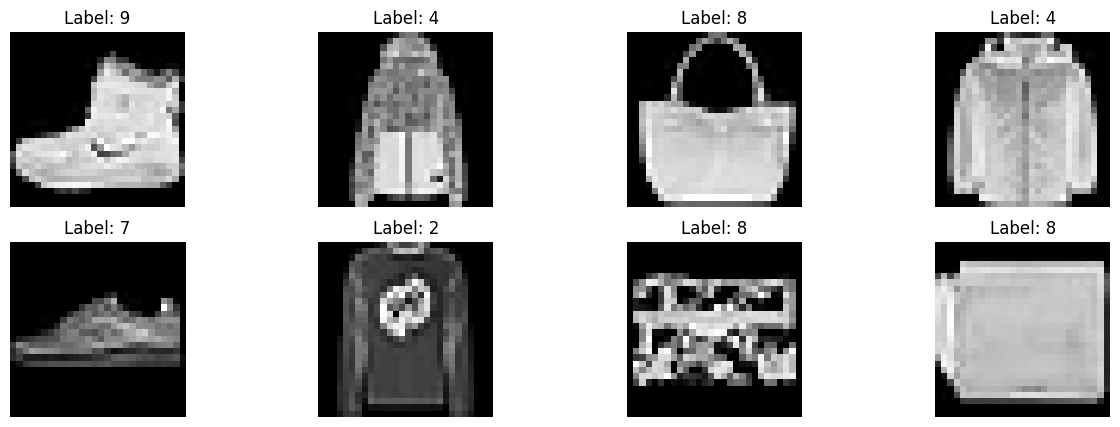

In [4]:
# Load the data and convert it (1, 2)
import numpy as np


transform = transforms.Compose([
    ToTensor(),
    Normalize(mean=0.2859, std=0.3530),
    transforms.Resize((28, 28))
])

training_data = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)
test_data = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

print(f"Train shape: {training_data.data.shape}")
print(f"Test shape: {test_data.data.shape}")


# create a dataloader (3)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)


# print sample data (4)
np.set_printoptions(linewidth=320)
indices = (0, 22, 100, 555, 666, 123, 10000, 55005)

fig, ax = plt.subplots(2, len(indices) // 2, figsize=(15, 5))
fig.subplots_adjust(wspace=0.3)
ax = ax.flatten()

for i, idx in enumerate(indices):
    img, label = train_dataloader.dataset[idx]
    ax[i].imshow(img.squeeze(), cmap="gray")
    ax[i].set_title(f"Label: {label}")
    ax[i].axis("off")

plt.show()


---
## 1. Replicate the Neural Network from the previous tasks for the FashionMNIST dataset
---


In the previous activity, you designed a fully connected neural network (a multi-layer perceptron) to predict on Fashion-MNIST.

1. Replicate the best network that you found in that activity, but in PyTorch.
1. Use [`summary`](https://pypi.org/project/torch-summary/) to display a summary of your model.
1. Use some random inputs to test the model. This will be meaningless, as the model is not trained yet (and the inputs are random). However, it is useful to test that you have defined the model at leats without any coding errors.

Hints and notes:
 * We need to [`Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) the incoming data. In the previous step, you loaded the dataset as a 28x28 image (because, later on we will be using CNNs that require image inputs). However, fully connected layers require vector inputs. `nn.Flatten` converts the image input to a vector (i.e., a 28x28 image to a 784 vector).
 * Use [`.to(device)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to "send" objects to the GPU (if you have one). E.g., once you define your class for the neural network, you will create an instance of that NN - you need to send this object to the GPU.
 * Generally, at inference time, we will use a [`softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) on the output of the model. Prior to the softmax, the model outputs a score per class. That is, there will be 10 outputs. However, here we will ignore the softmax part.


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [5]:
##############################
# Your code below

# my best model was (100,100,50)

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 50)
        self.out = nn.Linear(50, 10)
        
        self.relu = nn.ReLU()
        

    def forward(self, x):
        x = self.flatten(x)
        
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        
        return self.out(x)

model = NeuralNetwork().to(device)

summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              ReLU-3                  [-1, 100]               0
            Linear-4                  [-1, 100]          10,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 50]           5,050
              ReLU-7                   [-1, 50]               0
            Linear-8                   [-1, 10]             510
Total params: 94,160
Trainable params: 94,160
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.36
Estimated Total Size (MB): 0.37
----------------------------------------------------------------


In [6]:
random_input = torch.randn(1, 1, 28, 28).to(device)

output = model(random_input)

print(f"output shape: {output.shape}")

output shape: torch.Size([1, 10])


Now train the model.

We will use [Cross Entropy Loss](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e), and as discussed, the Adam optimiser (with learning rate = 0.001).

* Call the training loop - I would suggest a max of ~20 epochs
* Use matplotlib to plot the train and test loss, and the train and test accuracy
* Describe what you see in the graphs

This training could take a few minutes. But note how you will see a bunch of losses reported in each epoch? These are the mini-batches in Adam that we discussed before. Then there will be an overall Train and Test error reported for the Epoch.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [7]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model

##############################
# Your code below
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_dataloader,
    test_dataloader,
    model,
    loss_fn,
    optimizer,
    15
)

Epoch 1:

loss: 2.297664  [   64/60000]
loss: 0.726031  [ 6464/60000]
loss: 0.427827  [12864/60000]
loss: 0.507080  [19264/60000]
loss: 0.293123  [25664/60000]
loss: 0.460122  [32064/60000]
loss: 0.536589  [38464/60000]
loss: 0.423563  [44864/60000]
loss: 0.598777  [51264/60000]
loss: 0.331316  [57664/60000]
Train Error: 
 Accuracy: 86.0%, Avg loss: 0.373902 

Test Error: 
 Accuracy: 84.6%, Avg loss: 0.424487 

Epoch 2:

loss: 0.291349  [   64/60000]
loss: 0.366579  [ 6464/60000]
loss: 0.339241  [12864/60000]
loss: 0.285274  [19264/60000]
loss: 0.329060  [25664/60000]
loss: 0.361128  [32064/60000]
loss: 0.538792  [38464/60000]
loss: 0.457229  [44864/60000]
loss: 0.318500  [51264/60000]
loss: 0.441905  [57664/60000]
Train Error: 
 Accuracy: 87.4%, Avg loss: 0.337965 

Test Error: 
 Accuracy: 85.6%, Avg loss: 0.394061 

Epoch 3:

loss: 0.323931  [   64/60000]
loss: 0.420875  [ 6464/60000]
loss: 0.414790  [12864/60000]
loss: 0.257063  [19264/60000]
loss: 0.264446  [25664/60000]
loss: 0.26

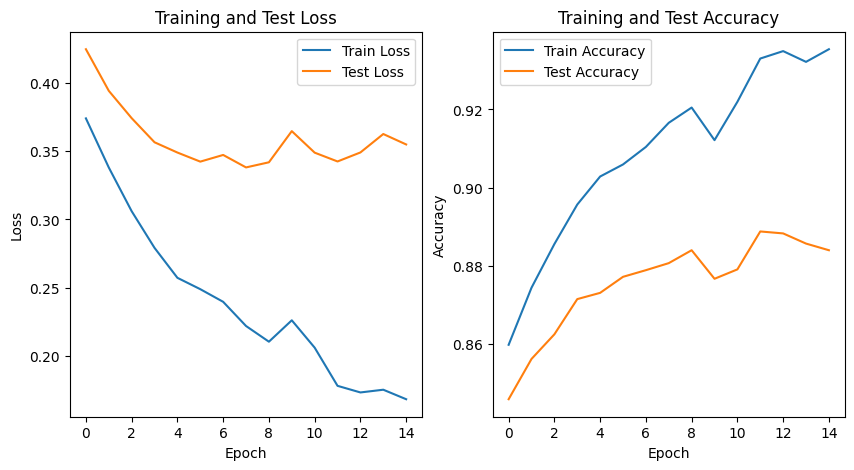

In [8]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(test_accuracy, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()

plt.show()

**Describe what you see in the graphs**




---

# 2. Replicate LeNet-5 for Fashion-MNIST

---


Below is the LeNet architecture (from https://en.wikipedia.org/wiki/LeNet). If you search on the internet, you will find slightly different implementations and descriptions of LeNet-5, but below is what was actually in LeCun's [original paper](https://ieeexplore.ieee.org/document/726791). Of course, LeCun was applying this to the digit recognition problem (MNIST), but we are looking at Fashion-MNIST.

 * Create the model in PyTorch.
 * Train the model using the same parameters as above, and plot the loss and accuracy.
 * Discuss and compare (in a markdown cell) with the fully connected model above. Particularly consider - number of parameters, performance, and overfitting?

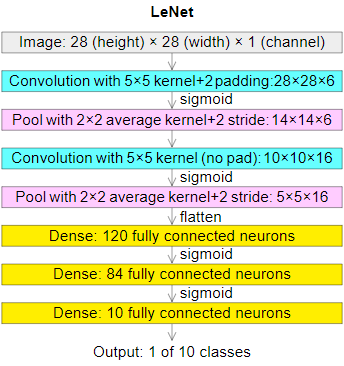

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [7]:
##############################
# Your code below
from torch.nn import functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        # 28x28x6
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)  
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2) 

        # 14x14x6 -> 10x10x16
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2) 

        # Flatten the tensor for the fully connected layers
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(5 * 5 * 16, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.sigmoid(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = torch.sigmoid(x)
        x = self.pool2(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = torch.sigmoid(x)

        x = self.fc2(x)
        x = torch.sigmoid(x)

        x = self.fc3(x)

        return F.softmax(x, dim=1)


# Instantiate the model
model = LeNet()
model.to(device)

summary(model, (1, 28, 28))

output = model(random_input)
output.shape

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
           Flatten-5                  [-1, 400]               0
            Linear-6                  [-1, 120]          48,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


torch.Size([1, 10])

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, 15
)

Epoch 1:

loss: 2.302775  [   64/60000]
loss: 2.273853  [ 6464/60000]
loss: 1.988633  [12864/60000]
loss: 1.859504  [19264/60000]
loss: 1.947385  [25664/60000]
loss: 1.908330  [32064/60000]
loss: 1.810867  [38464/60000]
loss: 1.858715  [44864/60000]
loss: 1.784603  [51264/60000]
loss: 1.709212  [57664/60000]
Train Error: 
 Accuracy: 74.8%, Avg loss: 1.727291 

Test Error: 
 Accuracy: 74.2%, Avg loss: 1.734664 

Epoch 2:

loss: 1.721997  [   64/60000]
loss: 1.755134  [ 6464/60000]
loss: 1.878831  [12864/60000]
loss: 1.687824  [19264/60000]
loss: 1.619253  [25664/60000]
loss: 1.648409  [32064/60000]
loss: 1.701064  [38464/60000]
loss: 1.678025  [44864/60000]
loss: 1.655296  [51264/60000]
loss: 1.725521  [57664/60000]
Train Error: 
 Accuracy: 77.4%, Avg loss: 1.690824 

Test Error: 
 Accuracy: 76.6%, Avg loss: 1.698333 

Epoch 3:

loss: 1.621523  [   64/60000]
loss: 1.746085  [ 6464/60000]
loss: 1.627515  [12864/60000]
loss: 1.615882  [19264/60000]
loss: 1.711508  [25664/60000]
loss: 1.63

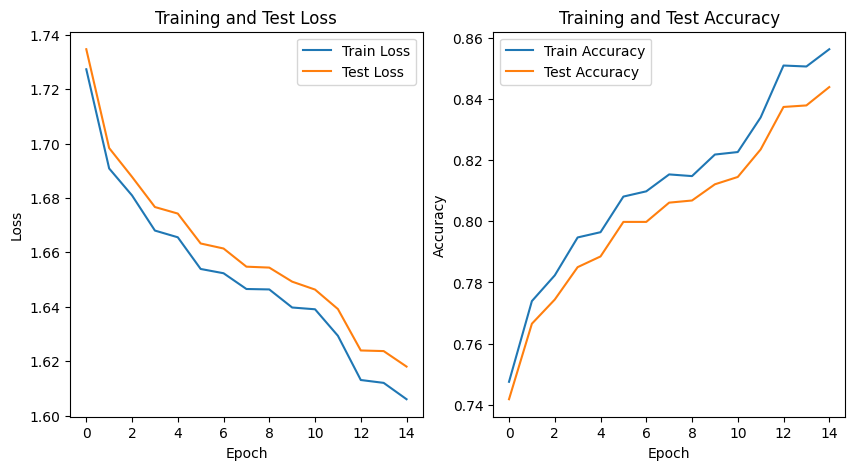

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(test_accuracy, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()

plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

#### Discuss and compare (in a markdown cell) with the fully connected model above. Particularly consider - number of parameters, performance, and overfitting
params (full connect - LeNet): 92,160 - 61,706
fully connected accuracy: 89% in test - 93% in train 
LeNet accuracy: 84% in test - 86% in train 


The LeNet model requires significantly fewer parameters than the fully connected model (about 2/3). It uses convolutional layers that extracts spatial hierarchies, reducing the number of weights compared to fully connected layers, which treat all input features as independent.

In this configuration, which only has 15 epochs, full connected model reachs better accuracy. However, the training graph suggests that LeNet has potential for further improvement with increased training time, as it continues to improve steadily, unlike the fully connected model, which converges by epoch 6. Furthermore, the similar shape of the 2 curves indicates better generalization.


From the graph, LeNet demonstrates lower overfitting, as evidenced by the small difference between its training and test accuracy curves. This suggests robust generalization. On the other hand, the fully connected model shows a 4% accuracy gap between training and testing, and this gap appears to grow exponentially with more epochs, indicating increasing overfitting.




---
# 3. Modernise LeNet
---


Modernise LeNet. What are the preferred activation and pooling functions for modern CNNs?

* Update LeNet with these newer functions.
* Train using the same parameters as above.
* Compare and discuss with the above using the normal discussion criteria


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [11]:
##############################
# Your code below

class ModernLeNet(nn.Module):
    def __init__(self):
        super(ModernLeNet, self).__init__()

        # 28x28x6
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)  
        self.batchnorm1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 

        # 14x14x6 -> 10x10x16
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(5 * 5 * 16, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)

        return F.softmax(x, dim=1)
    
model = ModernLeNet()
model.to(device)

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
       BatchNorm2d-2            [-1, 6, 28, 28]              12
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
       BatchNorm2d-5           [-1, 16, 10, 10]              32
         MaxPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
            Linear-9                   [-1, 84]          10,164
           Linear-10                   [-1, 10]             850
Total params: 61,750
Trainable params: 61,750
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.24
Estimated Tot

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, 15
)

Epoch 1:

loss: 2.306297  [   64/60000]
loss: 1.667968  [ 6464/60000]
loss: 1.700134  [12864/60000]
loss: 1.789428  [19264/60000]
loss: 1.627977  [25664/60000]
loss: 1.599468  [32064/60000]
loss: 1.607933  [38464/60000]
loss: 1.606105  [44864/60000]
loss: 1.637010  [51264/60000]
loss: 1.588846  [57664/60000]
Train Error: 
 Accuracy: 86.2%, Avg loss: 1.601402 

Test Error: 
 Accuracy: 85.5%, Avg loss: 1.608725 

Epoch 2:

loss: 1.606998  [   64/60000]
loss: 1.578471  [ 6464/60000]
loss: 1.592565  [12864/60000]
loss: 1.580119  [19264/60000]
loss: 1.611064  [25664/60000]
loss: 1.627020  [32064/60000]
loss: 1.549834  [38464/60000]
loss: 1.540563  [44864/60000]
loss: 1.583629  [51264/60000]
loss: 1.505388  [57664/60000]
Train Error: 
 Accuracy: 87.0%, Avg loss: 1.591309 

Test Error: 
 Accuracy: 86.0%, Avg loss: 1.601864 

Epoch 3:

loss: 1.681730  [   64/60000]
loss: 1.562523  [ 6464/60000]
loss: 1.523633  [12864/60000]
loss: 1.561964  [19264/60000]
loss: 1.547184  [25664/60000]
loss: 1.57

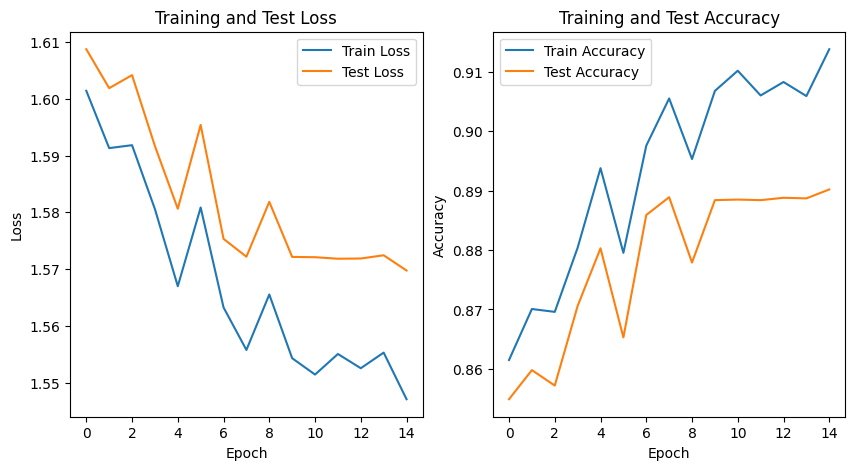

In [13]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(test_accuracy, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()

plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

In this model, I used ReLU for activation and MaxPooling, which helped the model converge faster. As a result, it achieved 89% accuracy—5% higher than the traditional model with the same configuration. However, the larger gap between training and testing accuracy may suggest that the modern approach may trade off generalization for a faster convergence rate.

---
# 4. Build your own CNN model
---

Build your own classifier model - see can you break 90% accuracy. You can use LeNet as a basis if you like.

With some networks I built, I could get 93 to 94% test accuracy.

Some hints:
 * not every convolutional layer needs a pooling layer afterwards
 * Consider adding more layers (maybe more 3x3 layers is better than 1 5x5 layer?)
 * But don't just bung loads of layers in there - you will end up overfitting badly
 * Use a [batchnorm](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) after each convolutional layer. You get decent performance gains without adding many parameters
 * Don't be afraid to get to a million or two parameters
 * Have a look on Google to see what others are doing (you're going to do this anyway, right?). Don't just copy them, though, try to understand.

Explain what you did that improved things for the classification and why they improved things.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [18]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=2)  
        self.batchnorm1 = nn.BatchNorm2d(64)
        # self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(0.2)

        # 64
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(4608, 120)
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(120, 84)
        self.dropout3 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout3(x)

        x = self.fc3(x)

        return x


model = CustomCNN()
model.to(device)

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]             640
       BatchNorm2d-2           [-1, 64, 30, 30]             128
         Dropout2d-3           [-1, 64, 30, 30]               0
            Conv2d-4           [-1, 64, 28, 28]          36,928
       BatchNorm2d-5           [-1, 64, 28, 28]             128
         MaxPool2d-6           [-1, 64, 14, 14]               0
            Conv2d-7          [-1, 128, 12, 12]          73,856
       BatchNorm2d-8          [-1, 128, 12, 12]             256
         MaxPool2d-9            [-1, 128, 6, 6]               0
          Flatten-10                 [-1, 4608]               0
           Linear-11                  [-1, 120]         553,080
          Dropout-12                  [-1, 120]               0
           Linear-13                   [-1, 84]          10,164
          Dropout-14                   

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, 15
)

Epoch 1:

loss: 2.277738  [   64/60000]
loss: 0.888553  [ 6464/60000]
loss: 0.416886  [12864/60000]
loss: 0.490839  [19264/60000]
loss: 0.376083  [25664/60000]
loss: 0.569694  [32064/60000]
loss: 0.446627  [38464/60000]
loss: 0.272625  [44864/60000]
loss: 0.385307  [51264/60000]
loss: 0.305597  [57664/60000]
Train Error: 
 Accuracy: 89.4%, Avg loss: 0.285372 

Test Error: 
 Accuracy: 88.6%, Avg loss: 0.310515 

Epoch 2:

loss: 0.452053  [   64/60000]
loss: 0.255184  [ 6464/60000]
loss: 0.367342  [12864/60000]
loss: 0.282294  [19264/60000]
loss: 0.395433  [25664/60000]
loss: 0.314551  [32064/60000]
loss: 0.239240  [38464/60000]
loss: 0.159981  [44864/60000]
loss: 0.236942  [51264/60000]
loss: 0.444066  [57664/60000]
Train Error: 
 Accuracy: 91.5%, Avg loss: 0.226171 

Test Error: 
 Accuracy: 90.4%, Avg loss: 0.265456 

Epoch 3:

loss: 0.322710  [   64/60000]
loss: 0.272606  [ 6464/60000]
loss: 0.315435  [12864/60000]
loss: 0.418042  [19264/60000]
loss: 0.213397  [25664/60000]
loss: 0.30

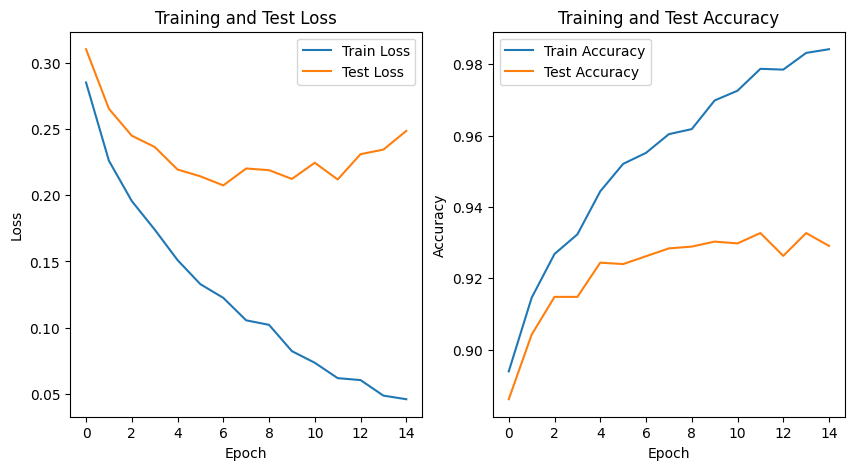

In [20]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(test_accuracy, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()

plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

Changes:

1. I added dropout layers: This prevents overfitting by ensuring that the model does not overly rely on specific neurons. It improves the generalization of the model on unseen data

2.  I added a third convolutional layer to improve the model's ability to learn more complex patterns while reduced the kernel size of the original convolutional layers from 5 to 3, which helps the model focus on finer details in the data and reduce computaion time.

3. I removed the pooling layer from the first convolutional layer because this layer is responsible for capturing basic features of the input. Pooling too early might discard critical information that’s essential for accurate classification.

---
# 5. Transfer Learning
---

Nobody trains large models from scratch. Rather, they use large pretrained models, that have been trained perhaps for weeks on very large datasets. Then, we can tweak the model for our needs. This allows us to use large models on small datasets and (hopefully) avoid some overfitting.

We are going to load ResNet18, we're going to cut the head off it - in this case, we will replace the very last layer. ResNet18 was trained for 1000 classes, we only have 10.

Do the following:
1. From `torchvision.models`, load [`ResNet18`](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html), and use random weights (`weights=None`). Replace the full-connected layer at the end with your own fully connect layer. Train and plot the loss and accuracy.
1. Repeat step 1, but use the default paramaters, and retrain. In this case, the default parameters.
1. Freeze all but the last layer of your adapted ResNet model, and retrain.
1. Provide some commentary on the three approaches. Particularly, what's the difference between all three approaches we outlined here?

For the freezing of layers, the following article is useful:
https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6

In step 3 above, we may see that the network doesn't necessarily perform as well as previous networks, in terms of test accuracy. Probably we should unfreeze more of the later layers to allow better fine-tuning of the network to our problem. And there are more complicated and powerful finetuning strategies out there. But you should see that overfitting is, more or less, solved. This is because we are only training a much smaller number of parameters, and freezing all of the convolution layers in the ResNet.


In [21]:
# We need to recreate the dataloaders, because ResNet expects a three channel
# RGB input, whereas FashionMNIST only has 1 channel (greyscale). Use
# `transforms.Grayscale(3)` to replicated the grayscale image into the three
# channels.

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

batch_size = 64
# Recreate the data loaders.
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [22]:
##############################
# Inspect the model

resnet18 = models.resnet18(weights=None)
resnet18.to(device)

summary(resnet18, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [24]:
model = resnet18

model.fc = nn.Linear(512, 10)  # previous layer output is 512
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, 15
)

Epoch 1:

loss: 2.589102  [   64/60000]
loss: 0.548692  [ 6464/60000]
loss: 0.345378  [12864/60000]
loss: 0.484620  [19264/60000]
loss: 0.539325  [25664/60000]
loss: 0.435729  [32064/60000]
loss: 0.327244  [38464/60000]
loss: 0.570351  [44864/60000]
loss: 0.333218  [51264/60000]
loss: 0.368549  [57664/60000]
Train Error: 
 Accuracy: 85.2%, Avg loss: 0.374014 

Test Error: 
 Accuracy: 83.3%, Avg loss: 0.416929 

Epoch 2:

loss: 0.297730  [   64/60000]
loss: 0.379013  [ 6464/60000]
loss: 0.257814  [12864/60000]
loss: 0.303141  [19264/60000]
loss: 0.310460  [25664/60000]
loss: 0.421923  [32064/60000]
loss: 0.282028  [38464/60000]
loss: 0.413225  [44864/60000]
loss: 0.247896  [51264/60000]
loss: 0.309570  [57664/60000]
Train Error: 
 Accuracy: 88.6%, Avg loss: 0.295842 

Test Error: 
 Accuracy: 87.0%, Avg loss: 0.349519 

Epoch 3:

loss: 0.194814  [   64/60000]
loss: 0.272689  [ 6464/60000]
loss: 0.224275  [12864/60000]
loss: 0.258751  [19264/60000]
loss: 0.219593  [25664/60000]
loss: 0.34

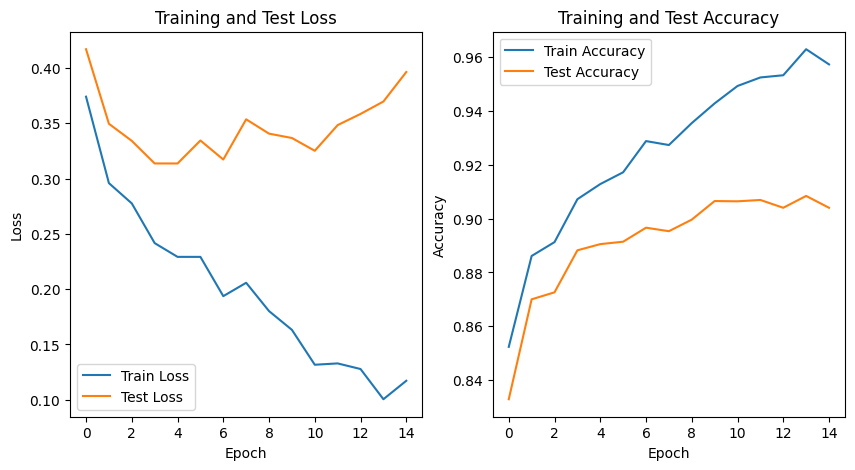

In [26]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(test_accuracy, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()

plt.show()

### 2. use the default parameters

In [27]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(512, 10)
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, 15
)


Epoch 1:

loss: 2.736784  [   64/60000]
loss: 0.415190  [ 6464/60000]
loss: 0.322423  [12864/60000]
loss: 0.433400  [19264/60000]
loss: 0.521297  [25664/60000]
loss: 0.463025  [32064/60000]
loss: 0.220068  [38464/60000]
loss: 0.458313  [44864/60000]
loss: 0.279991  [51264/60000]
loss: 0.275848  [57664/60000]
Train Error: 
 Accuracy: 87.2%, Avg loss: 0.349212 

Test Error: 
 Accuracy: 86.1%, Avg loss: 0.387590 

Epoch 2:

loss: 0.354561  [   64/60000]
loss: 0.389087  [ 6464/60000]
loss: 0.218035  [12864/60000]
loss: 0.271637  [19264/60000]
loss: 0.378096  [25664/60000]
loss: 0.385325  [32064/60000]
loss: 0.267199  [38464/60000]
loss: 0.417630  [44864/60000]
loss: 0.250571  [51264/60000]
loss: 0.194695  [57664/60000]
Train Error: 
 Accuracy: 89.8%, Avg loss: 0.271262 

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.318305 

Epoch 3:

loss: 0.196931  [   64/60000]
loss: 0.244713  [ 6464/60000]
loss: 0.228980  [12864/60000]
loss: 0.223834  [19264/60000]
loss: 0.224457  [25664/60000]
loss: 0.34

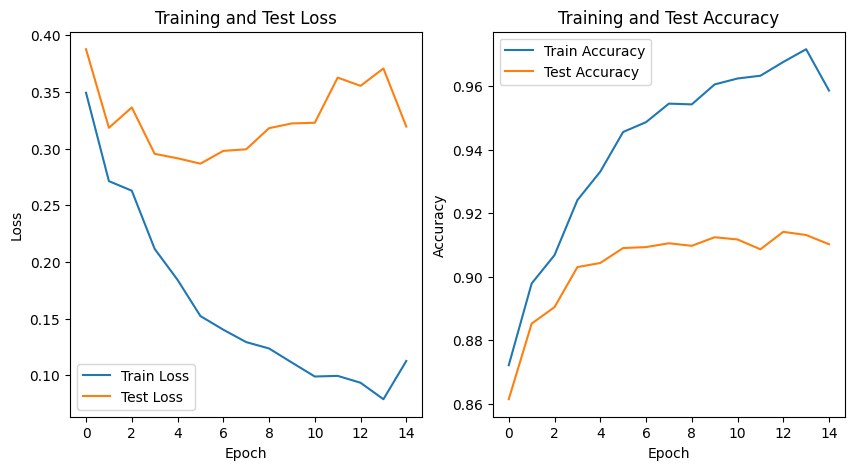

In [28]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(test_accuracy, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()

plt.show()

### 3 freeze resnet layers

In [29]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Linear(512, 10)
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, 15
)

Epoch 1:

loss: 2.591086  [   64/60000]
loss: 1.223443  [ 6464/60000]
loss: 0.938970  [12864/60000]
loss: 1.045243  [19264/60000]
loss: 0.993573  [25664/60000]
loss: 1.017963  [32064/60000]
loss: 0.877842  [38464/60000]
loss: 0.821164  [44864/60000]
loss: 1.096533  [51264/60000]
loss: 0.923933  [57664/60000]
Train Error: 
 Accuracy: 71.9%, Avg loss: 0.829870 

Test Error: 
 Accuracy: 70.8%, Avg loss: 0.857630 

Epoch 2:

loss: 0.866435  [   64/60000]
loss: 0.830936  [ 6464/60000]
loss: 0.800606  [12864/60000]
loss: 0.820654  [19264/60000]
loss: 0.818094  [25664/60000]
loss: 0.902312  [32064/60000]
loss: 0.809829  [38464/60000]
loss: 0.798868  [44864/60000]
loss: 1.073911  [51264/60000]
loss: 0.873947  [57664/60000]
Train Error: 
 Accuracy: 73.2%, Avg loss: 0.788714 

Test Error: 
 Accuracy: 71.6%, Avg loss: 0.827667 

Epoch 3:

loss: 0.846362  [   64/60000]
loss: 0.778095  [ 6464/60000]
loss: 0.775917  [12864/60000]
loss: 0.789162  [19264/60000]
loss: 0.776529  [25664/60000]
loss: 0.86

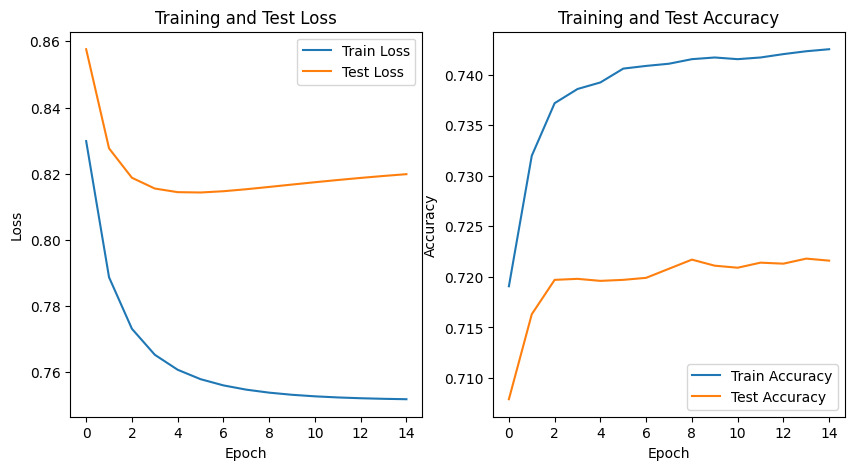

In [30]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(test_accuracy, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()

plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

Compare aproaches:

1. Start the model randomly: Meaning the model has no knowledge. We only get the model structure and have to train everything from scratch. In my opinion, there is no paticular advantage using this method.

1. Start the model with trained weights: The model has some knowledge about general objects and now it learns more about our specific objects. This results in faster convergence and generally higher accuracy with fewer epochs compared to training from scratch. We can see that in the graphs of 2 methods

1. Freezing the Pretrained Model: Training is significantly faster (about one-third the time of the other two methods), but the performance is not as good. We may need to add more layers or make further adjustments before the model becomes fully effective.





